Эксперимент проходил с 2023-01-01 по 2023-01-07 включительно. Для эксперимента были задействованы 2 и 1 группы.

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 


Задача — проанализировать данные АB-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравнить данные этими тестами. Посмотрить на распределения глазами. Почему тесты сработали так как сработали? 
3. Описать потенциальную ситуацию, когда такое изменение могло произойти.
4. Написать рекомендацию, раскатывать ли новый алгоритм на всех новых пользователей или нет.

In [92]:
# Запрос библиотек

import pandahouse
import pandas as pd
import seaborn as sns
import numpy as np

from scipy import stats

In [91]:
# Создание соединения

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}


In [93]:
# Запрос данных (пользователи, их просмотры и лайки из групп 1 и 2
#  во временной интервал с 01.01.23 по 07.01.23 включительно)

q = """

SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230120.feed_actions 
WHERE toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [ ]:
#T-тест на группах 1(контрольная) и 2(тестовая)

t_test = stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)
print(f' p-value = {t_test.pvalue}')

T-test не показывает различие в группах

In [ ]:
# Строим распределение CTR по группам и оцениваем его "наглаз".

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

На гистограмме явно видно различие в расспределении CTR в двух группах

Более того, у второй группы распределение с двумя вершинами

In [ ]:
# Тест Mann-Whitneyu

mann = stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')
print(f' p-value = {mann.pvalue}')


Тест Манна-Витни "покрасился" и показал значимое различие

-------------------------------------------------------------

In [ ]:
# Тест на сглаженном CTR

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    ''' Функция позволяет посчитать сглаженный CTR. 
    Когда у пользователя CTR близок к нулю, мы заменяем его на глобальный CTR.
    В остальных случаях CTR остаётся почти неизменным.
    Это помогает нам избавиться от "шума", который производят пользователи с малым количеством просмотров'''
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

# Считаем глобальный CTR в двух группах
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [ ]:
# Формируем базы данных двух групп с дополнительными колонками, в которых прописываем сглаженный CTR для каждого пользователя

group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [ ]:
#Проводим t-test на сглаженных данных

t_test_smothed = stats.ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var=False)
print(f' p-value = {t_test_smothed.pvalue}')

T-test на сглаженных данных показывает значемые различия

In [ ]:
# Строим расспределения сглаженного CTR в двух группах

sns.histplot(group1.smothed_ctr, kde = False)
sns.histplot(group2.smothed_ctr, kde = False, fill = False)

--------------------

Так как главной задачей является сравнение общего CTR в двух группах, а не CTR каждого пользователя, мы сталкиваемся с проблемой ,что общий CTR это одно число.

Чтобы уйти от этой проблемы мы генериуем из групп псевдовыборки методами Пуассоновского бустрепа и Бакетным преобразованием

In [ ]:
# Пуассоновский бутстреп


def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    ''' Функция принимает на вход массивы со значениями лайков и просмотров по пользователям в контрольной и тестовой группах.
    Также функция принимает количество выборок, которые будут сгенерированны. По умолчанию это 2000 шт
    Далее функция считает сколько раз значение like каждого пользователя попадёт в каждую из (2000)выборок. 
    Таким образом происходит формирование выборок в каждой из групп.
    poisson_bootstraps - массив с весами каждого значения в каждой из выборок.
    На выходе функция возвращает два массива из значений глобальнх CTR по всем выборкам в контрольной и тестовой группах '''

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [ ]:
#Формируем массивы с данными лайков и просмотров в контрольной и тестовой группах

likes1 = df[df.exp_group == 1].likes.to_numpy() # Массив с лайками в контрольной группе
views1 = df[df.exp_group == 1].views.to_numpy() # Массив с просмотрами в контрольной группе
likes2 = df[df.exp_group == 2].likes.to_numpy() # Массив с лайками в тестовой группе
views2 = df[df.exp_group == 2].views.to_numpy() # Массив с просмотрами в тестовой группе

In [ ]:
# Считаем распределение глобальных CTR в контрольной и тестовой группах, используя псевдовыборки в них. 
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

In [ ]:
# Строим распределения глобальных CTR в контрольной и тестовой группах по их псевдовыборкам
sns.set(rc={'figure.figsize':(20,8)})
sns.histplot(ctr1)
sns.histplot(ctr2, fill = False)

Графики не пересекаются, Т-тест должен показать p-value = 0.

При этом заметим, что  тестовая группа показывает меньший глобальный CTR

------------

In [86]:
t_test_gl = stats.ttest_ind(ctr1, ctr2, equal_var=False)
print(f' p-value = {t_test_gl.pvalue}')

 p-value = 0.0


<AxesSubplot:ylabel='Count'>

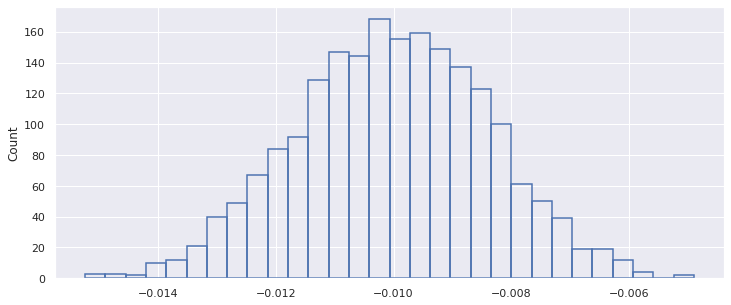

In [89]:
#Потроим разницу между глобальными CTR в группах
sns.set(rc={'figure.figsize':(12,5)})
sns.histplot(ctr2 - ctr1, fill= False)


Разница между глобальными CTR в тестовой и контрольной группе отрицательная, не пересекает 0.

Можно утверждать что тестовая группа показала худшие результаты чем контрольная

-----------------------------------------------------------------------------------------------------

In [101]:
# Запрос данных для бакетного преобразования

qb = """
SELECT exp_group, bucket,
sum(likes)/sum(views) as bucket_ctr
    FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20230120.feed_actions 
    WHERE toDate(time) between '2023-01-01' and '2023-01-07' and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_b = pandahouse.read_clickhouse(qb, connection=connection)

In [102]:
# T-test поверх бакетного преобразования контрольной и тестовой групп
t_test = stats.ttest_ind(df_b[df_b.exp_group == 1].bucket_ctr,
                df_b[df_b.exp_group == 2].bucket_ctr,
                equal_var=False)
print(f' p-value = {t_test.pvalue}')

 p-value = 3.4455951649945907e-07


In [104]:
# Mann-Whitneyu-test поверх бакетного преобразования контрольной и тестовой групп
mann_test = stats.mannwhitneyu(df_b[df_b.exp_group == 1].bucket_ctr, 
                   df_b[df_b.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')
print(f' p-value = {mann_test.pvalue}')

 p-value = 2.859963936492646e-07


----------------------------------------------------------------------------------

Первоначальные тесты на пользовательских CTR давали разные результаты.          
Т-тест на первичных данных не видел разниы в группах.         
Т-тест на сглаженном CTR и тест Mann-Whitneyu видел значительные различия в группах.
Посмотрев на распределения можно увидеть явное различие в группах. В тестовой группе распределение двугорбое.   
Т-тест на первичных данных считает различие в среднем и, видимо, среднее двугорбого распределения случайно совпало со средним в распределении контрольной группы.       

Двугорбое распределение в контрольной группе могло произойти из-за того, что нововедения выкатили на группу с некоторым количеством заинтересованных пользователей, которые активно лайкали при небольшом количестве просмотров.           
Однако основные пользователи не слишком оценили нововедения, что можно увидеть на дальнейшем исследовании глобального CTR.

Методы исследования глобального CTR показывают отрицательное влияние нововедений на измеряемую метрику.       
На мой взгляд, не стоит рекомендовать вводить изменения для всего приложения
